In [8]:
import time
import pyrealsense2 as rs
import numpy as np
import cv2
import jkrc
from HanglokJKRC import HagJkrc
import logging
import pandas as pd
from camera import Camera
import os
from datetime import datetime
from calibration.utils import *
import cv2.aruco as aruco
import logging

In [66]:

# Create a logger instance
logger = logging.getLogger("my_logger")
logger.setLevel(logging.DEBUG)


# 102 is left, 100 is right
arm  = HagJkrc(logger, "192.168.10.100")
arm.init_robot()
arm.read_actual_tcp_point_all()

finish ini robot


[-448.3441760273711,
 124.504115029758,
 636.2396581634708,
 -2.826607396680802,
 -0.16645790074595393,
 -3.072138040873851]

In [7]:
point = arm.read_actual_tcp_point_all()
print(point)
# 0 if for moving paralle to the windows, 1 is for moving vertical to the windows
point[1] += 50
print(point)
arm.move_to_point(point, 10)

[-506.6959043995959, 68.58641625713408, 643.1158247761168, -3.125434477892203, -0.019697983026996123, 2.785993547052592]
[-506.6959043995959, 118.58641625713408, 643.1158247761168, -3.125434477892203, -0.019697983026996123, 2.785993547052592]
[-506.6959043995959, 118.58641625713408, 643.1158247761168, -3.125434477892203, -0.019697983026996123, 2.785993547052592]
jaka is moving
jaka is moving
jaka is moving
jaka is moving
jaka is moving
jaka move to point successfully


(0,)

In [79]:

if 1:
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()
    print(config)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
    # Start streaming
#     pipeline.start(config)
    pf = pipeline.start(config) 
    device = pf.get_device()
    device.hardware_reset()

    print(rs.stream.intrinsics)

AttributeError: type object 'pyrealsense2.pyrealsense2.stream' has no attribute 'intrinsics'

In [88]:
import pyrealsense2 as rs

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.rgb8, 30)
cfg = pipeline.start(config)
device = cfg.get_device()
name = device.get_info(rs.camera_info.name)
print(name)
profile = cfg.get_stream(rs.stream.depth)
profile1 = cfg.get_stream(rs.stream.color)
intr = profile.as_video_stream_profile().get_intrinsics()
intr1 = profile1.as_video_stream_profile().get_intrinsics()
extrinsics = profile1.get_extrinsics_to(profile)
print(extrinsics)
# print("深度传感器内参：", intr)
print("RGB相机内参:", intr1)


Intel RealSense D435I
rotation: [0.999972, -0.00425782, 0.00612414, 0.00421796, 0.99997, 0.00650733, -0.00615167, -0.00648132, 0.99996]
translation: [-0.0147081, -0.000229996, -0.000613037]
RGB相机内参: [ 1280x720  p[637.773 375.817]  f[912.266 911.672]  Inverse Brown Conrady [0 0 0 0 0] ]


In [86]:
extrinsics.rotation[0]

0.9999721646308899

In [6]:

if __name__ == "__main__":
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()
    print(config)
    config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
    config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)
    # Start streaming
#     pipeline.start(config)
    pf = pipeline.start(config) 
    device = pf.get_device()
    device.hardware_reset()
    
    print(f"device: {pf.get_device()}")
    print(f"depth_sensor: {pf.get_device().first_depth_sensor()}")
    print(f"depth_scale: {pf.get_device().first_depth_sensor().get_depth_scale()}")
    print(f"streams: {pf.get_streams()}")

    try:
        while True:
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            if not depth_frame or not color_frame:
                continue
            # Convert images to numpy arrays
            
            aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_1000)
            parameters =  aruco.DetectorParameters()
            detector = aruco.ArucoDetector(aruco_dict, parameters)
            
            # # dst1 = cv2.undistort(frame, mtx, dist, None, newcameramtx)
            # corners, ids, rejectedImgPoints = aruco.detectMarkers(color_frame,aruco_dict,parameters=parameters)
            

            # if ids is not None:
            #     rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, mtx, dist)
            

            depth_image = np.asanyarray(depth_frame.get_data())
            color_image = np.asanyarray(color_frame.get_data())
            markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(color_image)
            print(markerCorners[0].shape)
            print(len(markerCorners))
            
            aruco.drawDetectedMarkers(color_image, markerCorners)


            

            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
            # Stack both images horizontally
            images = np.hstack((color_image, depth_colormap))
            # Show images
            cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            cv2.imshow('RealSense', images)
            key = cv2.waitKey(1)
            # Press esc or 'q' to close the image window
            if key & 0xFF == ord('q') or key == 27:
                cv2.destroyAllWindows()
                break
    finally:
        # Stop streaming
        pipeline.stop()

device: <pyrealsense2.device: Intel RealSense D435I (S/N: 213622070282  FW: 5.15.0.2  on USB3.2)>
depth_sensor: <pyrealsense2.sensor: "Stereo Module">
depth_scale: 0.0010000000474974513
streams: [<pyrealsense2.[video_]stream_profile: Depth(0) 1280x720 @ 30fps Z16>, <pyrealsense2.[video_]stream_profile: Color(0) 1280x720 @ 30fps BGR8>]
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1, 4, 2)
1
(1,

In [7]:
point = arm.read_actual_tcp_point_all()
print(point)
# 0 if for moving paralle to the windows, 1 is for moving vertical to the windows
point[1] += 50
print(point)
arm.move_to_point(start_pnt, 10)

NameError: name 'arm' is not defined

In [48]:
from calibration.utils import *

dir = f'C://Users//HP//Desktop//hzq//hanglok-robotics//calibration//saved/position.txt'
pnts = read_position(dir)
len(pnts)

23

In [49]:
pnts

[[16.882992294090556,
  -636.8184575742148,
  228.0553840320668,
  2.8609378241085235,
  0.06359254016376895,
  -2.10739318718454],
 [-170.2528677786724,
  -582.3123034305039,
  242.76910232926735,
  3.036483111237525,
  0.34653152202997145,
  -2.6384544977911104],
 [-92.30592001917731,
  -703.1613298376554,
  169.8859817783797,
  3.0408048933027665,
  0.11274981481604981,
  -2.3784159679778383],
 [-175.31288676394877,
  -672.487483876239,
  146.33055626688497,
  -3.0572163768922955,
  0.4783108861105716,
  -2.69804690012372],
 [89.92483433109555,
  -652.8605842667423,
  172.97268074170125,
  2.578726626013054,
  0.042783585233912416,
  -1.8334783953738998],
 [19.406701985387507,
  -614.063161964704,
  278.9589999959025,
  2.867076033857317,
  0.13039782360130087,
  -2.1322800600707605],
 [-34.03041044935338,
  -583.2987877723259,
  129.98255315151835,
  2.80441144645327,
  0.4445338394230623,
  -2.4386279280530636],
 [-38.906881762860344,
  -702.8379184463191,
  264.1719051828089,
  3

In [89]:
import time
import pyrealsense2 as rs
import numpy as np
import cv2
import jkrc
from HanglokJKRC import HagJkrc
import logging
import pandas as pd
from camera import Camera
import os
from datetime import datetime
from calibration.utils import *
import cv2.aruco as aruco
import logging
import matplotlib.pyplot as plt

In [2]:
pnts[0]

[16.882992294090556,
 -636.8184575742148,
 228.0553840320668,
 2.8609378241085235,
 0.06359254016376895,
 -2.10739318718454]

In [90]:
R,T = gripper2base(pnts[0])

NameError: name 'pnts' is not defined

In [6]:
R.shape

(3, 3)

In [7]:
T.shape

(3, 1)

In [96]:
def target2camera(img_path,aruco_dict,intr_matrix):
    ## the distortion coefficients of our camera is zero
    distCoeffs = np.zeros((5,1))

    img = cv2.imread(img_path)
    status = False
    R_target2camera = None
    rvec = None
    T_target2camera = None
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img)

    world_coor = np.zeros((4,3),dtype=np.float64)
    world_coor[0,:] = [500,500,0]
    world_coor[1,:] = [500,-500,0]
    world_coor[2,:] = [-500,-500,0]
    world_coor[3,:] = [-500,500,0]
    # world_coor[0,:] = [1000,1000,0]
    # world_coor[1,:] = [1000,0,0]
    # world_coor[2,:] = [0,0,0]
    # world_coor[3,:] = [0,1000,0]
    # world_coor[0,:] = [-500,500,0]
    # world_coor[1,:] = [500,500,0]
    # world_coor[2,:] = [500,-500,0]
    # world_coor[3,:] = [-500,-500,0]
 
    # if successfully detected 4 corner points
    if markerIds is not None:
        if markerCorners[0][0].shape[0] == 4:
            
            retval, rvec, T_target2camera = cv2.solvePnP(world_coor, markerCorners[0][0], intr_matrix, distCoeffs,flags=cv2.SOLVEPNP_IPPE_SQUARE)
            if retval:
                R_target2camera = angle2rotation(rvec[0][0],rvec[1][0],rvec[2][0])
                status = True
                # print(rvec)
    return status,R_target2camera,T_target2camera

In [92]:
def target2camera2(img_path,aruco_dict,intr_matrix):
    ## the distortion coefficients of our camera is zero
    distCoeffs = np.zeros((5,1))

    img = cv2.imread(img_path)
    status = False
    R_target2camera = None
    rvec = None
    T_target2camera = None
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img)

    world_coor = np.zeros((4,3),dtype=np.float64)
    # world_coor[0,:] = [500,500,0]
    # world_coor[1,:] = [500,-500,0]
    # world_coor[2,:] = [-500,-500,0]
    # world_coor[3,:] = [-500,500,0]
    world_coor[0,:] = [1000,1000,0]
    world_coor[1,:] = [1000,0,0]
    world_coor[2,:] = [0,0,0]
    world_coor[3,:] = [0,1000,0]
    # world_coor[0,:] = [-500,500,0]
    # world_coor[1,:] = [500,500,0]
    # world_coor[2,:] = [500,-500,0]
    # world_coor[3,:] = [-500,-500,0]
 
    # if successfully detected 4 corner points
    if markerIds is not None:
        if markerCorners[0][0].shape[0] == 4:
            
            retval, rvec, T_target2camera = cv2.solvePnP(world_coor, markerCorners[0][0], intr_matrix, distCoeffs,flags=cv2.SOLVEPNP_IPPE_SQUARE)
            if retval:
                R_target2camera = angle2rotation(rvec[0][0],rvec[1][0],rvec[2][0])
                status = True
                # print(rvec)
    return status,R_target2camera,T_target2camera

In [97]:
import json
cam_cal_data_path = f'C://Users//HP//Desktop//hzq//hanglok-robotics//calibration//calibration_data.json'
cali_data = json.load(open(cam_cal_data_path))
intrinsic_left = np.zeros((3,3))
intrinsic_right = np.zeros((3,3))
axis_lists =['x','y','z']
for i in range(3):
    for j in range(3):
        intrinsic_left[i,j] = float(cali_data['intrinsic_left.'+axis_lists[i]+'.'+axis_lists[j]])
        intrinsic_right[i,j] = float(cali_data['intrinsic_right.'+axis_lists[i]+'.'+axis_lists[j]])
intrinsic_matrix = (intrinsic_left+intrinsic_right)/2
intrinsic_matrix = np.array([[912.266, 0, 637.773],
                                        [0, 911.672, 375.817],
                                        [0,       0,       1]], dtype = "double")

array([[-0.54134081,  0.56695434, -0.62089685],
       [ 0.34239632, -0.52580503, -0.77864872],
       [-0.76792896, -0.63410713,  0.09051664]])

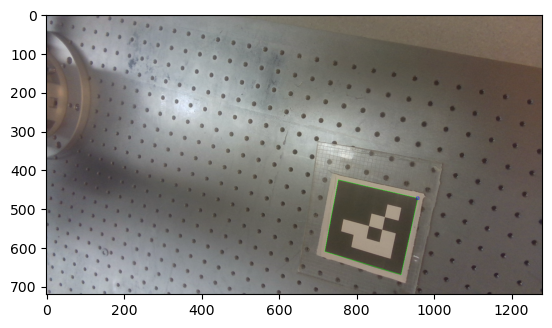

In [98]:
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_1000)
img_path = f'C://Users//HP//Desktop//hzq//hanglok-robotics//calibration//saved//5.png'
img = cv2.imread(img_path)
parameters =  aruco.DetectorParameters()
detector = aruco.ArucoDetector(aruco_dict, parameters)
markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img)

dist = np.zeros((5,1))

# rvec, tvec, _ = aruco.estimatePoseSingleMarkers(markerCorners, 0.05, intrinsic_matrix, dist)
aruco.drawDetectedMarkers(img, markerCorners)

# aruco.drawAxis(img, intrinsic_matrix, dist, rvec[i, :, :], tvec[i, :, :], 0.03)
# cv2.circle(img, tuple(np.uint32(markerCorners[0][0][0])), 20, (0, 255, 255))
plt.imshow(img)

status,R_target2camera,T_target2camera = target2camera(img_path,aruco_dict,intrinsic_matrix)
R_target2camera

In [72]:
T_target2camera

array([[-2.53870250e+01],
       [-5.50314351e+01],
       [ 1.26760619e-02]])

In [99]:
status,R_target2camera,T_target2camera = target2camera2(img_path,aruco_dict,intrinsic_matrix)
R_target2camera

array([[-0.54134081,  0.56695434, -0.62089685],
       [ 0.34239632, -0.52580503, -0.77864872],
       [-0.76792896, -0.63410713,  0.09051664]])

In [74]:
T_target2camera

array([[1.58711335e+02],
       [6.27689394e+02],
       [2.65209178e-01]])

In [33]:
world_coor = np.zeros((4,3))
world_coor[0,:] = [500,500,0]
world_coor[1,:] = [500,-500,0]
world_coor[2,:] = [-500,-500,0]
world_coor[3,:] = [-500,500,0]
world_coor

array([[ 500.,  500.,    0.],
       [ 500., -500.,    0.],
       [-500., -500.,    0.],
       [-500.,  500.,    0.]])

In [22]:
world_coor[0,:] = [500,500,0]

In [34]:
distCoeffs = np.zeros((5,1))
retval, rvec, tvec = cv2.solvePnP(world_coor, markerCorners[0][0], intrinsic_matrix,distCoeffs)

In [47]:
retval

True

In [45]:
angle2rotation(rvec[0][0],rvec[1][0],rvec[2][0])

array([[ 7.32637681e-01,  6.80618444e-01, -7.49476188e-04],
       [-6.80618736e-01,  7.32637763e-01, -2.09979725e-04],
       [ 4.06178484e-04,  6.63946594e-04,  9.99999697e-01]])

In [42]:
R = cv2.Rodrigues(rvec)[0]
R

array([[ 7.32637676e-01,  6.80618592e-01, -6.06415677e-04],
       [-6.80618849e-01,  7.32637545e-01, -4.58582137e-04],
       [ 1.32163364e-04,  7.48712491e-04,  9.99999711e-01]])

In [35]:
rvec.shape

(3, 1)

In [26]:
cali_data['intrinsic_right.y.z']

'0.0711922'

In [61]:
t = np.column_stack((R,tvec))
M = np.row_stack((t, np.array([0, 0, 0, 1])))


In [65]:
np.sum((M*0.001)**2)

72.58209858035903